In [1]:
import PIL
from PIL import Image
import librosa
import librosa.display
import numpy as np
from numpy import asarray
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

In [3]:
audio_path = 'data/genres_original/hiphop/hiphop.00005.wav'
x , sr = librosa.load(audio_path)#x is an audio time series as a numpy array. sr is the sampling rate
ipd.Audio(audio_path)

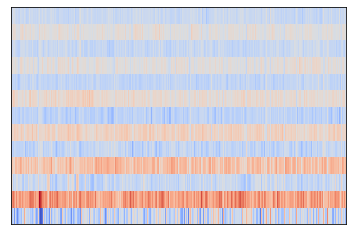

In [4]:
mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
fig, ax = plt.subplots()
mfcc_data = librosa.display.specshow(mfcc)
plt.savefig('mfccdata.png', bbox_inches='tight')


In [5]:
img = Image.open('mfccdata.png')
img = img.convert('RGB')
numpydata = np.array(img)
print(numpydata.shape)

(235, 352, 3)


In [25]:
def create_dataset(path, genre_list, dataset):
    
    row = 0
    for genre in genre_list:
        files = librosa.util.find_files(path+genre, ext=['wav'])#this returns the entire path for each file in a genre folder
        
        for song in files:
            x , sr = librosa.load(song)
            mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
            song_id = song[71+len(genre)+1:-4]#-4 - len(genre)
            
            mfcc_3d = librosa.display.specshow(mfcc)
            plt.savefig('data/images_mfccs/'+ str(row)+'.png', bbox_inches='tight')
            img = Image.open('data/images_mfccs/'+ str(row)+ '.png')
            img = img.convert('RGB')
            numpydata = np.array(img)
            

            dataset['song_id'].append(song_id) 
            dataset['MFCCs_color'].append(numpydata) #array of dimension (13, 216, 3)
            dataset['label'].append(genre)
            row+=1
            
    return dataset


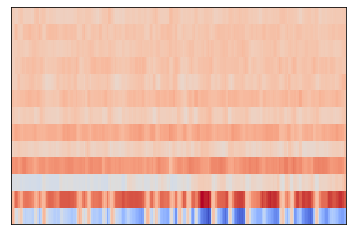

In [7]:
dataset = { 'song_id':[], 'MFCCs_color':[], 'label':[] }
path = 'data/data_fiveSeconds/'
genre_list = ['jazz', 'rock', 'hiphop', 'metal', 'pop', 'disco', 'blues', 'classical', 'country', 'reggae']
data_diz = create_dataset(path, genre_list, dataset)  

In [8]:
with open('DATA_MFCCs.pkl', 'wb') as f:
    pickle.dump(data_diz, f)

In [2]:
with open('DATA_MFCCs.pkl', 'rb') as f:
    DATA = pickle.load(f)

In [3]:
def prepare_datasets(inputs, targets, split_size):
      
    #scale the data
    mean = inputs.mean(axis=(1, 2), keepdims=True)
    std = inputs.std(axis=(1, 2), keepdims=True)
    inputs = (inputs-mean)/std
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, 
                                                                              test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    #inputs_train = inputs_train[..., np.newaxis]
    #inputs_val = inputs_val[..., np.newaxis]
    #inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test



def design_model_1(input_shape, targets):
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = "imagenet")
    base_model.trainable = False

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        base_model,
        
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3), 
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : 'jazz',
        1 : 'rock',
        2 : 'hiphop',
        3 : "metal",
        4 : "pop",
        5 : "disco",
        6 : "blues",
        7 : "classical",
        8 : "country",
        9 : "reggae",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])

In [4]:
X = np.array(DATA['MFCCs_color'])
y = np.array(DATA['label'])
y_encoded = pd.factorize(y.reshape(X.shape[0],))[0]
y_encoded = y_encoded.reshape(X.shape[0],1)
inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test = prepare_datasets(X, y_encoded, 0.1)

In [5]:
if __name__ == "__main__":
    

    model = design_model_1(inputs_train.shape[1:], y)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    # Training the model.
    history = model.fit(inputs_train, targets_train,
                        validation_data=(inputs_val, targets_val),
                        epochs=30,
                        batch_size=32
                        )

    # Testing the model on never seen before data.
    make_prediction(model, inputs_test, targets_test, 24)

C:\Users\carlo\miniconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 11, 1280)       2257984   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 6, 1280)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 6, 1280)        5120      
_________________________________________________________________
dropout (Dropout)            (None, 4, 6, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1966144   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [6]:
def design_model_1(input_shape, targets):
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = "imagenet")
    base_model.trainable = False

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        base_model,
        
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3), 
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

if __name__ == "__main__":
    

    model = design_model_1(inputs_train.shape[1:], y)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    # Training the model.
    history = model.fit(inputs_train, targets_train,
                        validation_data=(inputs_val, targets_val),
                        epochs=30,
                        batch_size=32
                        )

    # Testing the model on never seen before data.
    make_prediction(model, inputs_test, targets_test, 24)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 11, 1280)       2257984   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 6, 1280)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 6, 1280)        5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 6, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                983072    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [7]:
def design_model_1(input_shape, targets):
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = "imagenet")
    base_model.trainable = False

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        base_model,
        
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3), 
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

if __name__ == "__main__":
    

    model = design_model_1(inputs_train.shape[1:], y)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    # Training the model.
    history = model.fit(inputs_train, targets_train,
                        validation_data=(inputs_val, targets_val),
                        epochs=30,
                        batch_size=32
                        )

    # Testing the model on never seen before data.
    make_prediction(model, inputs_test, targets_test, 24)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 11, 1280)       2257984   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 6, 1280)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 6, 1280)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                983072    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 3,241,386
Trainable params: 983,402
Non-trainable params: 2,257,984
______________________________________

In [8]:
def design_model_1(input_shape, targets):
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape, include_top = False, weights = "imagenet")
    base_model.trainable = False

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        base_model,
        
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3), 
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

if __name__ == "__main__":
    

    model = design_model_1(inputs_train.shape[1:], y)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    # Training the model.
    history = model.fit(inputs_train, targets_train,
                        validation_data=(inputs_val, targets_val),
                        epochs=30,
                        batch_size=32
                        )

    # Testing the model on never seen before data.
    make_prediction(model, inputs_test, targets_test, 24)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 11, 1280)       2257984   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 6, 1280)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 6, 1280)        5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 6, 1280)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1966144   
_________________________________________________________________
dense_7 (Dense)              (None, 10)               